In [1]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import anndata
import h5py    
import numpy as np   
import scipy.sparse as sparse
import scipy.io as sio
import scipy.stats as stats

Global seed set to 0
/Users/mij51/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/mij51/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
adata_multi = sc.read_h5ad("./E18_mouse_Brain/multiomic.h5ad")

In [3]:
adata_multi

AnnData object with n_obs × n_vars = 3365 × 176722
    obs: 'celltype'
    var: 'gene_ids', 'feature_types'

In [4]:
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]

In [5]:
unique, counts = np.unique(adata_multi.var['feature_types'], return_counts=True)
dict(zip(unique, counts))

{'Gene Expression': 32285, 'Peaks': 144437}

In [6]:
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)

In [7]:
adata_mvi.obs

,celltype,batch_id,modality
AAACAGCCAACCGCCA-1_paired,Upper Layer,1,paired
AAACAGCCAAGGTCGA-1_paired,"RG, Astro, OPC",1,paired
AAACAGCCAGGAACAT-1_paired,Deeper Layer,1,paired
AAACAGCCATATTGAC-1_paired,Deeper Layer,1,paired
AAACAGCCATGGTTAT-1_paired,Subplate,1,paired
...,...,...,...
TTTGTGGCATAATCGT-1_paired,Ependymal cells,1,paired
TTTGTGGCATTTGCTC-1_paired,Upper Layer,1,paired
TTTGTGTTCAATGACC-1_paired,IPC,1,paired
TTTGTTGGTGGAGCAA-1_paired,Deeper Layer,1,paired


In [8]:
adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()
adata_mvi.var

,gene_ids,feature_types,modality
Xkr4,ENSMUSG00000051951,Gene Expression,Gene Expression
Gm48665,ENSMUSG00000113538,Gene Expression,Gene Expression
4930473H19Rik,ENSMUSG00000113087,Gene Expression,Gene Expression
3200001D21Rik,ENSMUSG00000113434,Gene Expression,Gene Expression
Adck1,ENSMUSG00000021044,Gene Expression,Gene Expression
...,...,...,...
chr15:74135780-74136320,chr15:74135780-74136320,Peaks,Peaks
chr15:74145642-74146636,chr15:74145642-74146636,Peaks,Peaks
chr15:74147408-74149040,chr15:74147408-74149040,Peaks,Peaks
chr15:74069085-74069355,chr15:74069085-74069355,Peaks,Peaks


In [9]:
print(adata_mvi.shape)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))
print(adata_mvi.shape)

(3365, 176722)
(3365, 138466)


In [10]:
scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key='modality')

In [11]:
mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
)
mvi.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.4.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│          n_vars          │ 138466 │
│         n_cells          │  3365  │
│         n_batch          │   1    │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
└──────────────────────────┴────────┘

               Data Registry               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃   scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │         adata.X          │
│    batch     │ adata.obs['_scvi_batch'] │
└──────────────┴──────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

In [13]:
mvi.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mij51/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(


Epoch 1/500:   0%|                                      | 0/500 [00:00<?, ?it/s]

/Users/mij51/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/module/_multivae.py:557: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1660136236989/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


Epoch 358/500:  72%|▋| 358/500 [3:25:00<1:21:19, 34.36s/it, loss=1.63e+04, v_num
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 35652.438. Signaling Trainer to stop.


In [15]:
mvi.save("trained_multivi")

In [21]:
import logging
from functools import partial
from typing import Dict, Iterable, List, Optional, Sequence, Union
import numpy as np
import pandas as pd
import torch
from anndata import AnnData
from scipy.sparse import csr_matrix, vstack
from torch.distributions import Normal
from scvi import REGISTRY_KEYS
from scvi._compat import Literal
from scvi._types import Number
from scvi._utils import _doc_params
from scvi.data import AnnDataManager
from scvi.data.fields import (
    CategoricalJointObsField,
    CategoricalObsField,
    LayerField,
    NumericalJointObsField,
    NumericalObsField,
)
from scvi.dataloaders import DataSplitter
from scvi.model._utils import (
    _get_batch_code_from_category,
    scatac_raw_counts_properties,
    scrna_raw_counts_properties,
)
from scvi.model.base import UnsupervisedTrainingMixin
from scvi.module import MULTIVAE
from scvi.train import AdversarialTrainingPlan, TrainRunner
from scvi.train._callbacks import SaveBestState
from scvi.utils._docstrings import doc_differential_expression, setup_anndata_dsp
from scvi.model import MULTIVI
from scvi.model.base import BaseModelClass, VAEMixin
from scvi.model.base._utils import _de_core

In [22]:
class MultiVI_Parallel(MULTIVI):
    def __init__(
        self,
        adata: AnnData,
        n_genes: int,
        n_regions: int,
        n_hidden: Optional[int] = None,
        n_latent: Optional[int] = None,
        n_layers_encoder: int = 2,
        n_layers_decoder: int = 2,
        dropout_rate: float = 0.1,
        region_factors: bool = True,
        gene_likelihood: Literal["zinb", "nb", "poisson"] = "zinb",
        use_batch_norm: Literal["encoder", "decoder", "none", "both"] = "none",
        use_layer_norm: Literal["encoder", "decoder", "none", "both"] = "both",
        latent_distribution: Literal["normal", "ln"] = "normal",
        deeply_inject_covariates: bool = False,
        encode_covariates: bool = False,
        fully_paired: bool = False,
        **model_kwargs,
    ):
        super().__init__(adata,
        n_genes,
        n_regions,
        n_hidden,
        n_latent,
        n_layers_encoder,
        n_layers_decoder,
        dropout_rate,
        region_factors,
        gene_likelihood,
        use_batch_norm,
        use_layer_norm,
        latent_distribution,
        deeply_inject_covariates,
        encode_covariates,
        fully_paired,
        **model_kwargs,)
    @torch.no_grad()
    def get_latent_representation(
        self,
        adata: Optional[AnnData] = None,
        modality: Literal["joint", "expression", "accessibility"] = "joint",
        indices: Optional[Sequence[int]] = None,
        give_mean: bool = True,
        batch_size: Optional[int] = None,
    ) -> np.ndarray:
        """
        Return the latent representation for each cell.
        Parameters
        ----------
        adata
            AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
            AnnData object used to initialize the model.
        modality
            Return modality specific or joint latent representation.
        indices
            Indices of cells in adata to use. If `None`, all cells are used.
        give_mean
            Give mean of distribution or sample from it.
        batch_size
            Minibatch size for data loading into model. Defaults to `scvi.settings.batch_size`.
        Returns
        -------
        latent_representation : np.ndarray
            Low-dimensional representation for each cell
        """
        if not self.is_trained_:
            raise RuntimeError("Please train the model first.")
        keys = {"z": "z", "qz_m": "qz_m", "qz_v": "qz_v", "z_expr": "z_expr",
        "qzm_expr": "qzm_expr", "qzv_expr": "qzv_expr", "z_acc": "z_acc", "qzm_acc": "qzm_acc", "qzv_acc": "qzv_acc"}
        adata = self._validate_anndata(adata)
        scdl = self._make_data_loader(
            adata=adata, indices=indices, batch_size=batch_size
        )
        latent = []
        latent_expr = []
        latent_atac = []
        for tensors in scdl:
            inference_inputs = self.module._get_inference_input(tensors)
            outputs = self.module.inference(**inference_inputs)
            qz_m = outputs[keys["qz_m"]]
            qz_v = outputs[keys["qz_v"]]
            z = outputs[keys["z"]]
            qzm_expr = outputs[keys["qzm_expr"]]
            qzv_expr = outputs[keys["qzv_expr"]]
            z_expr = outputs[keys["z_expr"]]
            qzm_acc = outputs[keys["qzm_acc"]]
            qzm_acc = outputs[keys["qzv_acc"]]
            z_acc = outputs[keys["z_acc"]]
            if give_mean:
                # does each model need to have this latent distribution param?
                if self.module.latent_distribution == "ln":
                    samples = Normal(qz_m, qz_v.sqrt()).sample([1])
                    z = torch.nn.functional.softmax(samples, dim=-1)
                    z = z.mean(dim=0)
                    samples_expr = Normal(qzm_expr, qzv_expr.sqrt()).sample([1])
                    z_expr = torch.nn.functional.softmax(samples_expr, dim=-1)
                    z_expr = z_expr.mean(dim=0)
                    samples_atac = Normal(qzm_acc, qzm_acc.sqrt()).sample([1])
                    z_acc = torch.nn.functional.softmax(samples_atac, dim=-1)
                    z_acc = z_acc.mean(dim=0)
                else:
                    z = qz_m
                    z_acc = qzm_acc
                    z_expr = qzm_expr
            latent += [z.cpu()]
            latent_atac+= [z_acc.cpu()]
            latent_expr += [z_expr.cpu()]
        return torch.cat(latent).numpy() , torch.cat(latent_atac).numpy(), torch.cat(latent_expr).numpy()

In [31]:
MultiVI_Parallel.setup_anndata(adata_mvi, batch_key='modality')

In [32]:
mvi_p = MultiVI_Parallel(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
)
mvi_p.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.4.

Setup via `MultiVI_Parallel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│          n_vars          │ 138466 │
│         n_cells          │  3365  │
│         n_batch          │   1    │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
└──────────────────────────┴────────┘

               Data Registry               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃   scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │         adata.X          │
│    batch     │ adata.obs['_scvi_batch'] │
└──────────────┴──────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

In [34]:
mvi_p.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mij51/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(


Epoch 282/500:  56%|▌| 282/500 [2:35:19<2:00:04, 33.05s/it, loss=1.65e+04, v_num
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 35622.820. Signaling Trainer to stop.


In [44]:
mvi.save("trained_multivi_P")

In [37]:
z,z_atac,z_rna = mvi_p.get_latent_representation()

In [41]:
from numpy.linalg import inv
import pandas as pd
df_meta= pd.read_csv("E18_mouse_Brain/RNA/metadata.tsv",sep = "\t",index_col=0)

In [40]:
X = z_atac
Y = z_rna
b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.sum(np.abs(Y_Residual),axis=1)

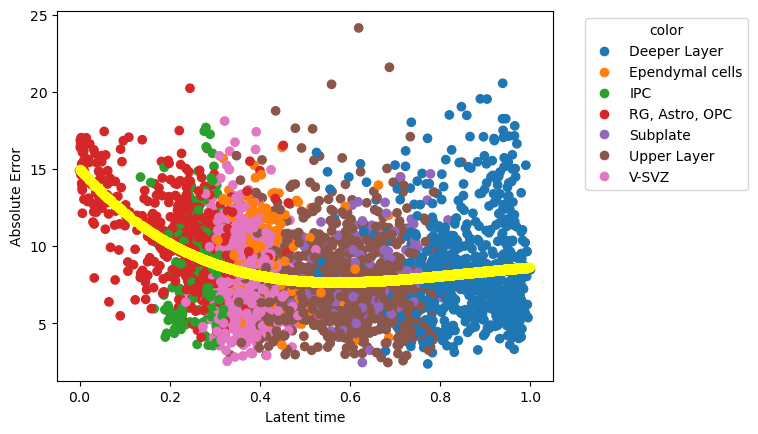

In [43]:
import tkinter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for legend handle


colors = {'Deeper Layer':'tab:blue', 'Ependymal cells':'tab:orange', 'IPC':'tab:green', 'RG, Astro, OPC':'tab:red', 
          'Subplate':'tab:purple', 'Upper Layer':'tab:brown', 'V-SVZ':'tab:pink'}

%matplotlib inline
plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

In [48]:
adata_RNA_sub  = adata_multi[:, adata_multi.var['feature_types'] == 'Gene Expression']
sc.pp.normalize_per_cell(adata_RNA_sub)
sc.pp.log1p(adata_RNA_sub)

/Users/mij51/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [55]:
Y = adata_RNA_sub.X.toarray()

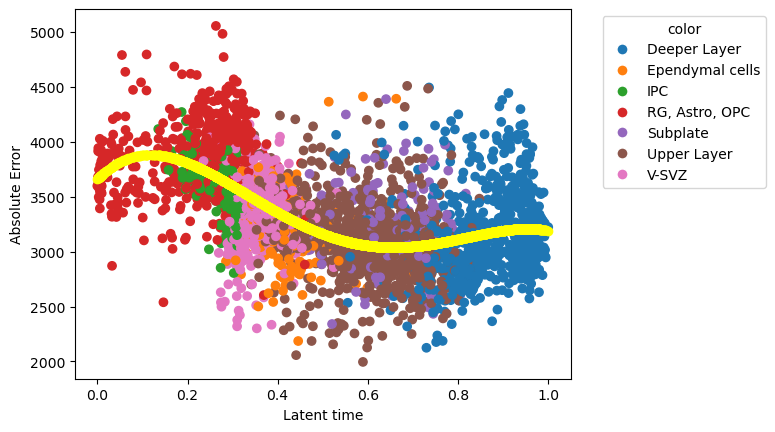

In [56]:
X = z_atac
b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.sum(np.abs(Y_Residual),axis=1)


%matplotlib inline
plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()